In [23]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
import matplotlib.pyplot as plt
import os
from shapely.geometry import Point
import ast  

path = "/Users/claireconzelmann/Documents/GitHub/KIHC-affordable-housing-analysis"

In [32]:
tif_districts = pd.read_csv(os.path.join(path, "Data/Raw/Boundaries_Tax_Increment_Financing_Districts.csv"))
city_land = pd.read_csv(os.path.join(path, "Data/Raw/City-Owned_Land_Inventory_20250320.csv"))
l_stops = pd.read_csv(os.path.join(path, "Data/Raw/CTA_System_Information_List_of_L_Stops.csv"))
bus_stops_gdf = gpd.read_file(os.path.join(path, "Data/Raw/CTA_BusStops.shp"))

#create geopandas objects
tif_districts["the_geom"] = tif_districts["the_geom"].apply(wkt.loads)
tif_districts_gdf = gpd.GeoDataFrame(tif_districts, geometry="the_geom")
tif_districts_gdf = tif_districts_gdf.set_crs(epsg=4326, inplace=True)

city_land_gpd = gpd.GeoDataFrame(city_land, 
                                 geometry=gpd.points_from_xy(city_land.Longitude, 
                                                             city_land.Latitude), 
                                 crs="EPSG:4326")

# Convert string representation of tuples of long/lat in lstop data into actual tuples
l_stops["Location"] = l_stops["Location"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

l_stops["geometry"] = l_stops["Location"].apply(lambda x: Point(x[1], x[0]))
l_stops_gdf = gpd.GeoDataFrame(l_stops, geometry="geometry")
l_stops_gdf.set_crs(epsg=4326, inplace=True)

bus_stops_gdf.set_crs(epsg=4326, inplace=True)

,SYSTEMSTOP,STREET,CROSS_ST,DIR,POS,ROUTESSTPG,OWLROUTES,CITY,PUBLIC_NAM,geometry
0,5282.0,JEFFERY,97TH STREET,NB,MT,15,None,CHICAGO,Jeffery & 97th Street,POINT (-87.57521 41.71888)
1,1143.0,STOCKTON,WEBSTER,NB,NT,"151,156",None,CHICAGO,Stockton & Webster,POINT (-87.63563 41.92192)
2,15703.0,HARLEM,SCHNEIDER,NB,NS,90,None,OAK PARK,Harlem & Schneider,POINT (-87.80512 41.89619)
3,6501.0,WENTWORTH,3200 SOUTH,SB,MB,"24,31",None,CHICAGO,3200 S Wentworth,POINT (-87.63168 41.83648)
4,1593.0,MICHIGAN,14TH STREET,SB,FS,"1,3,4",N4,CHICAGO,Michigan & 14th Street,POINT (-87.62419 41.86388)
...,...,...,...,...,...,...,...,...,...,...
10755,18379.0,HARLEM,AUGUSTA,NB,FS,90,None,OAK PARK,Harlem & Augusta,POINT (-87.80521 41.89799)
10756,18084.0,69TH STREET,DAMEN,EB,FS,67,None,CHICAGO,69th Street & Damen,POINT (-87.67337 41.76837)
10757,10274.0,CICERO,21ST STREET,NB,NS,54,None,CICERO,Cicero & 21st Street,POINT (-87.7442 41.8531)
10758,7111.0,STONY ISLAND,84TH STREET,NB,NS,28,None,CHICAGO,Stony Island & 84th Street,POINT (-87.5853 41.74246)


<Axes: >

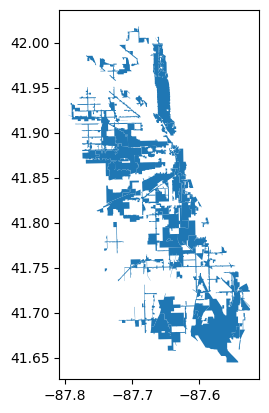

In [8]:
tif_districts_gdf.plot()

<Axes: >

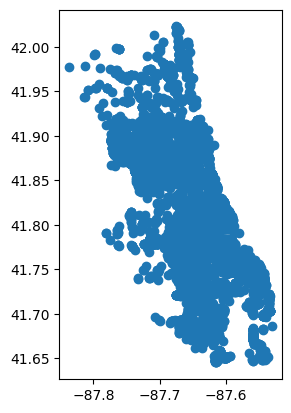

In [7]:
city_land_gpd.plot()

<Axes: >

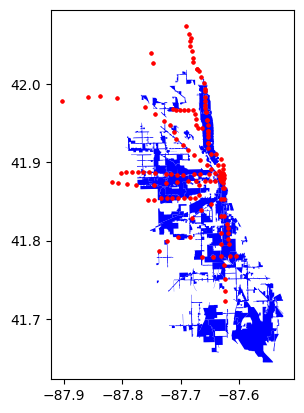

In [40]:
fig, ax = plt.subplots()

# Plot the first GeoDataFrame
tif_districts_gdf.plot(ax=ax, color='blue')

# Plot the second GeoDataFrame on the same axes
l_stops_gdf.plot(ax=ax, color='red', markersize=4)

<Axes: >

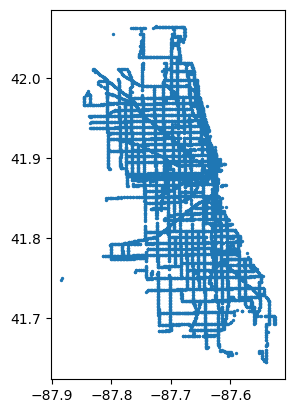

In [43]:
bus_stops_gdf.plot(markersize=2)